In [1]:
import pandas as pd
import polars as pl
import numpy as np
import lightgbm as lgb

import os
import matplotlib.pyplot as plt

In [ ]:
# base_path = '/content/drive/MyDrive/DMEyF/2024/'
base_path = 'C:/Eugenio/Maestria/DMEyF/'
# base_path = '/home/eanegrin/buckets/b1/'

dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_02_fe_v01.parquet'

ganancia_acierto = 273000
costo_estimulo = 7000

In [ ]:
semillas = [1149, 4836, 9443, 7483, 3492, 6287,  830, 3294, 5932,  815, 7070,
       1529, 3454, 6073, 7831, 1069, 3632,  953,  368, 3999, 9981,  906,
       6792, 1439, 8439, 9240, 8162,   32, 5785, 1013, 2747, 2702, 4807,
       831, 3985, 4003, 4758, 7955, 3976, 5436, 8634, 2511, 8627, 6888,
       4179, 1565, 9181, 6389, 5879, 1216, 8749, 8996,   99, 1481, 4120,
       8561, 7008, 5624,  271, 5204, 9169, 2537, 4070, 5458, 7383,  137,
       8414, 6327, 3119, 5659, 2907, 9390, 7055, 9770, 9614, 6769,  694,
       7854, 9925, 7895, 5259, 9598, 6352, 7884, 5592, 7017, 7374, 2208,
       7364, 1995, 7264, 2520, 3922, 7704, 2333, 1601, 2534, 6556, 9072,
       3046]

In [3]:
data = pl.scan_parquet(dataset_path + dataset_file).filter(pl.col("foto_mes") == 202106).collect()

In [4]:
# convierto a pandas dataframe
data = data.to_pandas()

In [5]:
# Asignamos pesos a las clases

data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [6]:
data['clase_binaria'] = 0
data['clase_binaria'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)

In [7]:
X_test = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_test = data['clase_binaria']
w_test = data['clase_peso']

Cargo los modelos pre-entrenados

In [8]:
version = 'v016'

modelos_folder = modelos_path + version

modelos = [f'{modelos_folder}/{modelo}' for modelo in os.listdir(modelos_folder)]

In [9]:
len(modelos)

100

In [10]:
X_test_with_predictions = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1).copy()

In [13]:
counter = 0

for modelo in modelos:
    
    # cargamos el modelo
    model = lgb.Booster(model_file=modelo)
    
    # predecimos para agosto
    X_test = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1).copy()
    y_pred_lgm = model.predict(X_test)
    X_test_with_predictions[f'pred_lgm_{semillas[counter]}'] = y_pred_lgm
    
    print(f'Predicciones del modelo: {modelo} DONE')
    
    counter += 1

Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1013.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1069.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1149.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1216.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s137.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1439.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1481.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1529.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1565.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1601.

C:\Users\eaneg\AppData\Local\Temp\ipykernel_23084\3231993701.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_with_predictions[f'pred_lgm_{semillas[counter]}'] = y_pred_lgm


Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s9925.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s9981.txt DONE


C:\Users\eaneg\AppData\Local\Temp\ipykernel_23084\3231993701.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_with_predictions[f'pred_lgm_{semillas[counter]}'] = y_pred_lgm


In [14]:
X_test_with_predictions = X_test_with_predictions.copy()

In [ ]:
y_pred_lgm = X_test_with_predictions.iloc[:, -100:].mean(axis=1)

ganancia = np.where(w_test == 1.00002, ganancia_acierto, 0) - np.where(w_test != 1.00002, costo_estimulo, 0)
    
idx = np.argsort(y_pred_lgm)[::-1]
ganancia = ganancia[idx]

ganancia_cum = np.cumsum(ganancia)
ganancia_max = ganancia_cum.max()
ganancia_max

np.int64(115948000)

In [16]:
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]
gan_max_idx

np.int64(11715)

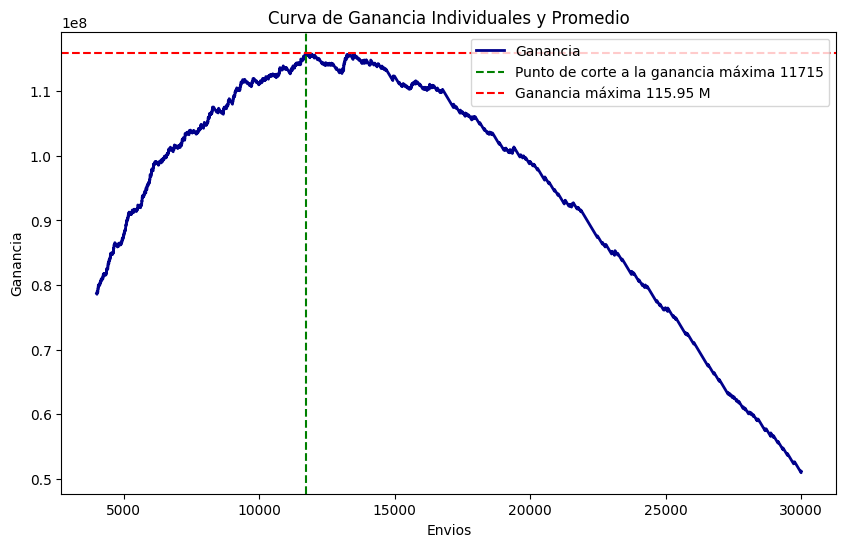

In [17]:
piso_envios = 4000
techo_envios = 30000

plt.figure(figsize=(10, 6))

plt.plot(
    range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
    ganancia_cum[piso_envios:techo_envios],
    color='darkblue',
    linewidth=2,
    label='Ganancia'
)

plt.axvline(
    x=gan_max_idx,
    color='g',
    linestyle='--',
    label=f'Punto de corte a la ganancia máxima {gan_max_idx}'
)

plt.axhline(
    y=ganancia_max,
    color='r',
    linestyle='--',
    label=f'Ganancia máxima {ganancia_max/1000000:.2f} M'
)

plt.title('Curva de Ganancia Individuales y Promedio')
plt.xlabel('Envios')
plt.ylabel('Ganancia')
plt.legend()
plt.show()